<a href="https://colab.research.google.com/github/15108326/ANAE/blob/master/ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
rdkit is already installed


In [0]:
# General Imports
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
try:

    %tensorflow_version 1.x  # %tensorflow_version only exists in Colab

except Exception:

    pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x  # %tensorflow_version only exists in Colab`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
smifile = "GDBMedChem.smi"
data = pd.read_csv(smifile, delimiter = " ", names = ["smiles","No"])
data=data[0:60000]
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(45000,)
(15000,)


In [0]:
smiles_test

12628         Cc1ccc2Cc3c(csc3C(C)(C)C)-c2c1
37730                CC(O)C1(C)CC(C)C[NH2+]1
39991          CC12CCC(CO)C1=CC(C[NH3+])C2CO
8525     CC1(C)CC(C(=O)C1)c1ccc2C[NH2+]Cc2c1
8279                 CC(O)CN1CC(=O)C(=C1)C#N
                        ...                 
15381                 CC(O)C1(OCC1[NH3+])C#C
928            CC(OCC(C)C([O-])=O)C(C)C(N)=O
27497        Cc1ccc(c(=N)o1)C1(C)CC(CO)CC1=O
50554          CC1=CCCC[NH+]2CCC(C2)=CC1(C)C
3673         Cc1c(COCC#C)ncc([NH+]=C(N)N)c1O
Name: smiles, Length: 15000, dtype: object

In [0]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print(str( charset))
print(len(charset), embed)

{'[', '!', 'O', ']', '(', 'c', 's', 'o', 'N', 'C', '+', ')', '-', 'E', '2', 'S', '1', 'F', 'n', '#', '3', '=', 'l', 'H'}
24 58


CC1=C2CC(=CC=CC=CC=C2)C(=O)C1


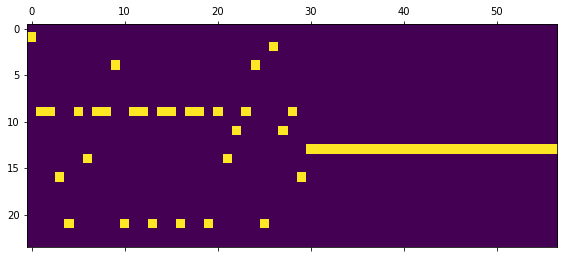

In [0]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [0]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!CC1=C2CC(=CC=CC=CC=C2)C(=O)C1EEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [0]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

Using TensorFlow backend.


In [0]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [0]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 57, 24)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  22784       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           lstm_1[0][1]                     
                                                                 lstm_1[0][2]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        concatenate_1[0][0]        

In [0]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [0]:
model.fit([X_train,X_train],Y_train,
                    epochs=10,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 45000 samples, validate on 15000 samples
Epoch 1/10





45000/45000 [==============================] - 47s 1ms/step - loss: 0.9463 - val_loss: 0.6109
Epoch 2/10
45000/45000 [==============================] - 46s 1ms/step - loss: 0.5548 - val_loss: 0.5109
Epoch 3/10
45000/45000 [==============================] - 45s 1ms/step - loss: 0.4931 - val_loss: 0.4869
Epoch 4/10
45000/45000 [==============================] - 45s 1ms/step - loss: 0.4627 - val_loss: 0.4488
Epoch 5/10
45000/45000 [==============================] - 45s 996us/step - loss: 0.4452 - val_loss: 0.4544
Epoch 6/10
45000/45000 [==============================] - 45s 1ms/step - loss: 0.4294 - val_loss: 0.4129
Epoch 7/10
45000/45000 [==============================] - 45s 996us/step - loss: 0.4027 - val_loss: 0.3877
Epoch 8/10
45000/45000 [==============================] - 45s 1000us/step - loss: 0.3869 - val_loss: 0.3737
E

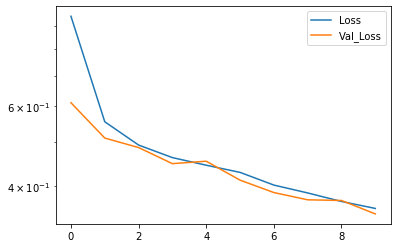

In [0]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [0]:
for i in range(100):
    v = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(v, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print(true, pred)

Cc1ccc2Cc3c(csc3C(C)(C)C)-c2c1EEEEEEEEEEEEEEEEEEEEEEEEEE Cc1ccc2CC3ccCcc2CCC)(C)CCcc1c1EEEEEEEEEEEEEEEEEEEEEEEEEE
CC(O)C1(C)CC(C)C[NH2+]1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(O)C1CC)CCCC)CCNH2+]1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC12CCC(CO)C1=CC(C[NH3+])C2COEEEEEEEEEEEEEEEEEEEEEEEEEEE CC1CCCCCCC)CCCCC(C)NH3+])CCCOEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1(C)CC(C(=O)C1)c1ccc2C[NH2+]Cc2c1EEEEEEEEEEEEEEEEEEEEE CC1(CCCCCCCCO)CC)C1ccc(CCNH2+]CC2c1EEEEEEEEEEEEEEEEEEEEE
CC(O)CN1CC(=O)C(=C1)C#NEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(O)C11CC(=O)CCCO))C#NEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
Cc1nc2c(CC(CC#CCC=C2C)=NO)s1EEEEEEEEEEEEEEEEEEEEEEEEEEEE Cc1cc2C(CCCC)2C)C2C))CcC))n1EEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1C2CCC1C(C)=CCCC=CCC2[NH3+]EEEEEEEEEEEEEEEEEEEEEEEEEEE CC1=2CCCCCCCCCCCC((CCC1CNH3+]EEEEEEEEEEEEEEEEEEEEEEEEEEE
CC(O)(CCc1ccno1)c1ccon1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(O)CCC#1cccc1)C1Ccn11EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
CC1(CO)CC(=O)CC[NH2+]1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC1(C))CC(CO)CCCNH2+]1EEEEEEEEE

In [0]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [0]:
latent_input = Input(shape=(latent_dim,))
#reuse_layers
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")

In [0]:
#Last one is special, we need to change it to stateful, and change the input shape
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)


In [0]:
#Transfer Weights
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

In [0]:
sample_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (1, 1, 24)                0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 64)                22784     
_________________________________________________________________
dense_5 (Dense)              (1, 1, 24)                1560      
Total params: 24,344
Trainable params: 24,344
Non-trainable params: 0
_________________________________________________________________


In [0]:
x_latent = smiles_to_latent_model.predict(X_test)

[    5  6600  6931  6780  7864  6403  9797  7881 13135  9130]
51012     Cc1nc2c(CC(CC#CCC=C2C)=NO)s1
4859     Cc1cc2CCCc3c(c[nH]c3-c2o1)C#C
48843    Cc1cc2CC#CC=CC(C)=C(C)c1[nH]2
41433    Cc1cc2C=CCC3(C)CC3CC#Cc1[nH]2
51053     Cc1cc2CCC(C#C)=C(C)C(O)c2cn1
33929     Cc1cc2CC(Nc2c2c1OCC2(C)C)C#N
4283      Cc1cc2CC=CC=CC(C)=Cn2c(=O)c1
42127     Cc1cc2CC(CC3(CCCC3)C#N)Cc2s1
Name: smiles, dtype: object


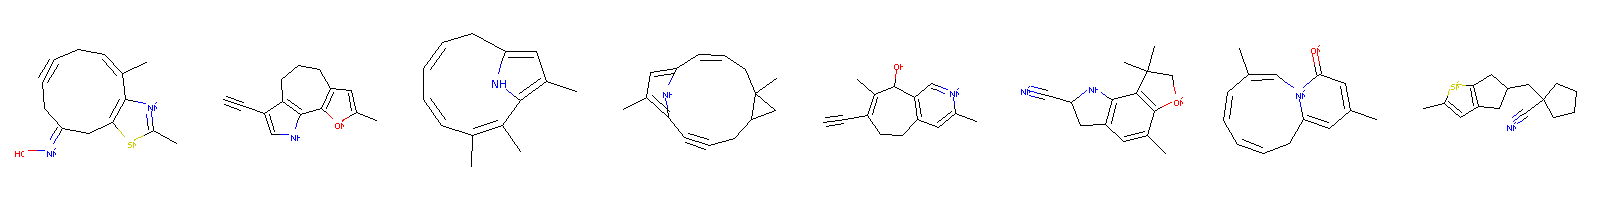

In [0]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:10])
print(smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

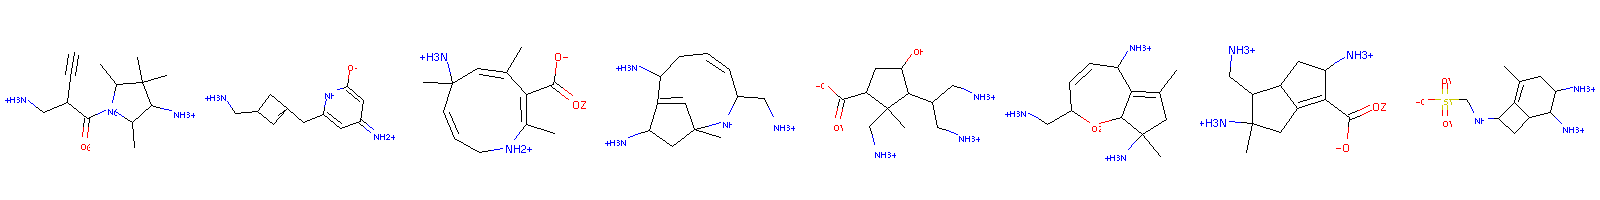

In [0]:
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

In [0]:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

[0.75136757 0.20749316] 0.95886075


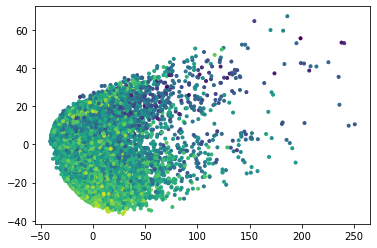

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

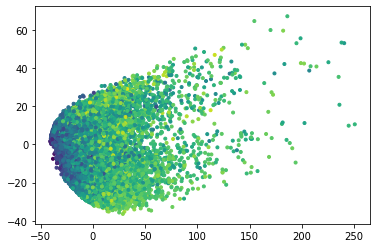

In [0]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

In [0]:
#Model LogP?
x_train_latent = smiles_to_latent_model.predict(X_train)
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)

In [0]:
from keras.models import Sequential
logp_model = Sequential()
logp_model.add(Dense(128, input_shape=(latent_dim,), activation="relu"))
logp_model.add(Dense(128, activation="relu"))
logp_model.add(Dense(1))
logp_model.compile(optimizer="adam", loss="mse")


In [0]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=100, callbacks = [rlr])


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/100
45000/45000 [==============================] - 2s 44us/step - loss: 1.9714
Epoch 2/100
 4736/45000 [==>...........................] - ETA: 1s - loss: 1.5146

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


45000/45000 [==============================] - 1s 32us/step - loss: 1.5393
Epoch 3/100
45000/45000 [==============================] - 1s 33us/step - loss: 1.5092
Epoch 4/100
45000/45000 [==============================] - 1s 31us/step - loss: 1.4938
Epoch 5/100
45000/45000 [==============================] - 1s 32us/step - loss: 1.4865
Epoch 6/100
45000/45000 [==============================] - 1s 33us/step - loss: 1.4670
Epoch 7/100
45000/45000 [==============================] - 1s 32us/step - loss: 1.4401
Epoch 8/100
45000/45000 [==============================] - 1s 32us/step - loss: 1.4253
Epoch 9/100
45000/45000 [==============================] - 2s 33us/step - loss: 1.4410
Epoch 10/100
45000/45000 [==============================] - 1s 33us/step - loss: 1.4133
Epoch 11/100
45000/45000 [==============================] - 1s 32us/step - loss: 1.4051
Epoch 12/100
45000/45000 [==============================] - 1s 31us/step - loss: 1.4124
Epoch 13/100
45000/45000 [==========================

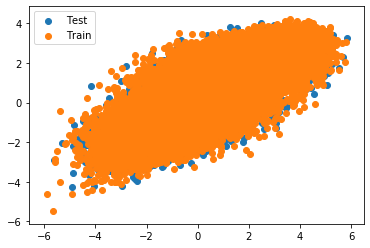

In [0]:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")
plt.scatter(logp_train, logp_pred_train, label="Train")
plt.legend()


In [0]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,22))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [0]:
smiles = latent_to_smiles(x_latent[0:1])
print(smiles)
print(smiles_test.iloc[0])

ValueError: ignored

In [0]:
wrong = 0
for i in range(1000):
    smiles = latent_to_smiles(x_latent[i:i+1])
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        print(smiles)
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(1000)*100))


In [0]:
#Interpolation test in latent_space
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    #print r
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)

In [0]:
#Sample around the latent wector
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)